In [3]:
# push!(LOAD_PATH, "../src")
using Revise
using DifferentialEquations
using Thyrosim
using Plots

In [4]:
ic, p = initialize()
tspan = (0.0, 720.0)

prob = ODEProblem(original_thyrosim, ic, tspan, p)
sol = solve(prob)

In [ ]:
plot(sol)

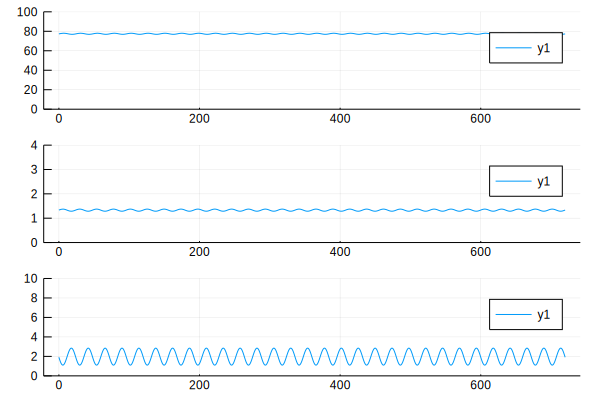

In [5]:
p1 = plot(sol.t, 777.0 * sol[1, :] / p[47], ylim=(0, 100))
p2 = plot(sol.t, 651.0 * sol[4, :] / p[47], ylim=(0, 4))
p3 = plot(sol.t, 5.6 * sol[7, :] / p[48], ylim=(0, 10))
plot(p1, p2, p3, layout=(3, 1))

## Implementing dosing

Let's first try to incorporate a single T4 dose into the model at 24 hours.

In [39]:
ic, p = initialize();
tspan = (0.0, 720.0);

function condition(u, t, integrator)
    return t - 24.0
end
    
function affect!(integrator)
    T4_dose = 1.6 * 70.0 / 777.0;
    T3_dose = 0.0;
    
    ## CHECK: Should probably be adding to pill compartments 10, 12 but do this same way as Simon's code so
    ## we can compare.
    integrator.u[11] += T4_dose
    integrator.u[13] += T3_dose
end

cbk = ContinuousCallback(condition, affect!);

prob = ODEProblem(original_thyrosim, ic, tspan, p, callback=cbk);
sol = solve(prob);

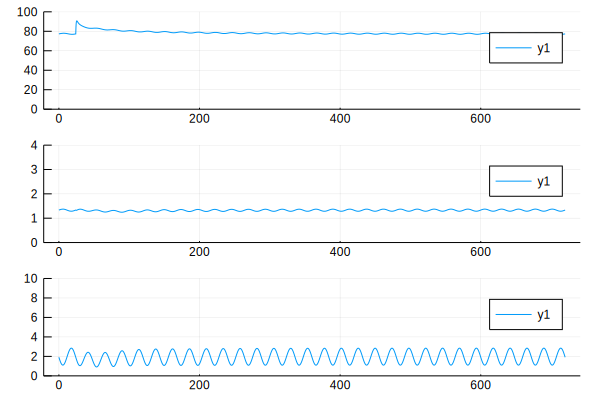

In [40]:
p1 = plot(sol.t, 777.0 * sol[1, :] / p[47], ylim=(0, 100))
p2 = plot(sol.t, 651.0 * sol[4, :] / p[47], ylim=(0, 4))
p3 = plot(sol.t, 5.6 * sol[7, :] / p[48], ylim=(0, 10))
plot(p1, p2, p3, layout=(3, 1))

This works! It's may not be straightforward to generalize this, but let's see if we can get it to do periodic dosing.

In [42]:
using DiffEqCallbacks

In [102]:
function output_plot(sol)
    p1 = plot(sol.t / 24.0, 777.0 * sol[1, :] / p[47], ylim=(0, 115), label="",
       ylabel="T4", title="Thyrosim simulation")
    p1 = hline!([45, 105], label= "")
    
    p2 = plot(sol.t / 24.0, 651.0 * sol[4, :] / p[47], ylim=(0, 4), label="", 
       ylabel="T3")
    p2 = hline!([0.6, 1.8], label= "")
    
    p3 = plot(sol.t / 24.0, 5.6 * sol[7, :] / p[48], ylim=(0, 10), label="",
       ylabel="TSH", xlabel="time [hours]")
    p3 = hline!([0.45, 4.5], label= "")
    
    plot(p1, p2, p3, layout=(3, 1))
end
    

output_plot (generic function with 1 method)

In [103]:
ic, p = initialize([0.0, 0.0, 0.0, 0.0]);
tspan = (0.0, 720.0);

#function condition(u, t, integrator)
#    return t - 24.0
#end
    
function affect!(integrator)
    T4_dose = 1.6 * 70.0 / 777.0;
    T3_dose = 0.0;
    
    ## CHECK: Should probably be adding to pill compartments 10, 12 but do this same way as Simon's code so
    ## we can compare.
    integrator.u[11] += T4_dose
    integrator.u[13] += T3_dose
end

cbk = PeriodicCallback(affect!, 24.0);

prob = ODEProblem(original_thyrosim, ic, tspan, p, callback=cbk);
sol = solve(prob);

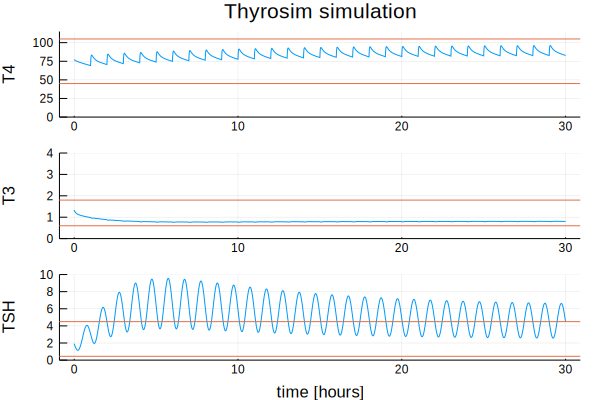

In [104]:
output_plot(sol)

This works! Now it only remains to try and get it to only start giving doses at specific places.

In [109]:
ic, p = initialize([0.0, 0.0, 0.0, 0.0]);
tspan = (0.0, 720.0);

#function condition(u, t, integrator)
#    return t - 24.0
#end
    
function affect!(t, u, integrator)
    T4_dose = 1.6 * 70.0 / 777.0;
    T3_dose = 0.0;
    
    ## CHECK: Should probably be adding to pill compartments 10, 12 but do this same way as Simon's code so
    ## we can compare.
    integrator.u[11] += T4_dose
    integrator.u[13] += T3_dose
end
cbk = FunctionCallingCallback(affect!;
                 funcat=[24.0, 48.0, 72.0, 100.0],
                 func_start = false)

prob = ODEProblem(original_thyrosim, ic, tspan, p, callback=cbk);
sol = solve(prob);

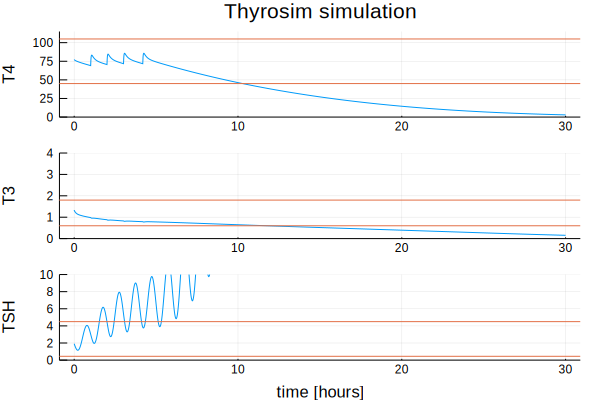

In [110]:
output_plot(sol)